### Install or import dependencies

In [16]:
### From: https://colab.research.google.com/drive/1VWoGcpyqGvrUOUzH7ccppE__m-n1cAiI?usp=sharing#scrollTo=x10crvpWAnog
!pip3 install --quiet -U ncps pytorch-lightning

In [14]:
### From: https://colab.research.google.com/drive/1VWoGcpyqGvrUOUzH7ccppE__m-n1cAiI?usp=sharing#scrollTo=x10crvpWAnog
import numpy as np
import torch.nn as nn
from ncps.wirings import AutoNCP
from ncps.torch import LTC, CfC
import pytorch_lightning as pl
import torch
import torch.utils.data as data
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
try:
    import torchdiffeq
except ModuleNotFoundError:
    !pip install --quiet torchdiffeq
    import torchdiffeq
import numpy as np
import torch
import torch.nn as nn
import torchdiffeq as diff
from torchdiffeq import odeint
import csv
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, ExponentialLR
import time
import random
import os
import logging
import matplotlib.pyplot as plt

print(torchdiffeq.__version__)

0.2.3


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # Read data
# filename = "/content/drive/MyDrive/EC523 Final Project/Data/simulated_dataset-42_G=1_sumSteps=200.csv"

# with open(filename, 'r') as csvfile:
#     trajs = torch.tensor([[float(value) for value in row] for row in csv.reader(csvfile)])

In [5]:
# # define function to round down to nearest number
# def rounddown(x, number):
#   '''Rounds down to the nearest multiple of number specified'''
#   return int(x // number) * number

# # split data into training, validation, and testing
# # trajectories are randomly initiated, so there is no need to further randomize

# rows = trajs.shape[0]
# train_split = 0.7*0.1202 # Use portion of dataset
# val_split = 0.15*0.1202

# train_stop = rounddown(rows*train_split, 200)
# val_stop = train_stop + rounddown(rows*val_split, 200)

# train_data = trajs[:train_stop,:]
# val_data = trajs[train_stop:val_stop,:]
# test_data = trajs[val_stop:,:]

train_file = "/content/drive/MyDrive/EC523 Final Project/Data/simulated_dataset-42_G=1_sumSteps=200_TRAIN.csv"
val_file = "/content/drive/MyDrive/EC523 Final Project/Data/simulated_dataset-42_G=1_sumSteps=200_VAL.csv"
test_file = "/content/drive/MyDrive/EC523 Final Project/Data/simulated_dataset-42_G=1_sumSteps=200_TEST.csv"

# np.savetxt(train_file, train_data, delimiter=",")
# np.savetxt(val_file, val_data, delimiter=",")
# np.savetxt(test_file, test_data, delimiter=",")

In [6]:
# Dataset for evaluation
class CustomDatasetLTC(Dataset):
    def __init__(self, filename, device, num_gpus, num_steps = 200): # can take as input files
        with open(filename, 'r') as csvfile:
          reader = csv.reader(csvfile)
          self.trajs = torch.tensor([[float(value) for value in row] for i,row in enumerate(reader)])

        self.num_steps = num_steps

    def __getitem__(self, idx):

        start_index = self.num_steps*idx
        end_index = start_index + self.num_steps

        input_ic = self.trajs[start_index,4:] # take initial condition
        input_pad = torch.zeros([self.num_steps-1, 12]) # pad with zeros

        input = torch.cat([input_ic.unsqueeze(0), input_pad], dim = 0)
        label = self.trajs[start_index:end_index,4:] # take whole trajectory as label

        return input, label

    def __len__(self): # return length of dataset
        if len(self.trajs) % self.num_steps != 0:
            raise ValueError("Total number of rows in the dataset is not divisible by num_steps")

        length = len(self.trajs)//self.num_steps
        return length

In [7]:
### From https://colab.research.google.com/drive/1VWoGcpyqGvrUOUzH7ccppE__m-n1cAiI?usp=sharing#scrollTo=x10crvpWAnog

# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [8]:
def graph_traj(model_traj, sim_traj):
# Choose which state array to use to make sure they're all the same
# state_array = states_all
# state_array = states_all_reshaped
  num_steps = 200
  dim = 2
  sim_state_array = sim_traj.cpu()
  model_state_array = model_traj.cpu()

# Set a seed for reproducibility
  rng_plot = np.random.default_rng(seed=42069)

# Randomly select rows from 'state_array'
  random_indices = rng_plot.choice(len(sim_state_array), size=4, replace=False)  # size = 4 so we can do a 2x2 grid
  sim_selected_rows = sim_state_array[random_indices,0,:] # use the same random indicies from above
  model_selected_rows = model_state_array[random_indices,0,:]

# Add a column for random indices
  sim_selected_rows_with_indices = np.column_stack((sim_selected_rows, random_indices))
  model_selected_rows_with_indices = np.column_stack((model_selected_rows, random_indices))
  fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex='all', sharey = 'all')
  axs = axs.flatten()

# Perform simulations and plot trajectories for both functions
  for i, row in enumerate(sim_selected_rows_with_indices):
    idx = int(row[-1]) # index from full list of initial conditions

    sim_states = sim_state_array[idx,:,1:] # remove time column (not really necessary)
    model_states = model_state_array[idx,:,1:] # remove time column (not really necessary)
    sim_positions_over_time_flat = sim_state_array[idx,:,-12:-6]
    sim_velocities_over_time_flat = sim_state_array[idx,:,-6:]
    model_positions_over_time_flat = model_state_array[idx,:,-12:-6]
    model_velocities_over_time_flat = model_state_array[idx,:,-6:]

    # Reshape for plotting
    sim_positions_over_time = sim_positions_over_time_flat.reshape((num_steps, 3, dim))
    sim_velocities_over_time = sim_velocities_over_time_flat.reshape((num_steps, 3, dim))
    sim_initial_velocities = sim_velocities_over_time[0]
    model_positions_over_time = model_positions_over_time_flat.reshape((num_steps, 3, dim))
    model_velocities_over_time = model_velocities_over_time_flat.reshape((num_steps, 3, dim))
    model_initial_velocities = model_velocities_over_time[0]

    # Plot
    sim_colors = ['#E69F00', '#56B4E9', '#9e0010']
    ax_lim = 2
    for particle_number in range(3):
      x = sim_positions_over_time[:, particle_number, 0]
      y = sim_positions_over_time[:, particle_number, 1]
      color = sim_colors[particle_number]
      axs[i].plot(
            x, y,
            color=color, label=f'Particle {particle_number + 1}'
      )
      axs[i].scatter(x[0], y[0], s=20, color=color, marker='o', label=f'_Initial Position Particle {particle_number + 1}')
      axs[i].set_xlim([-ax_lim, ax_lim])
      axs[i].set_ylim([-ax_lim, ax_lim])

      # Plot initial velocity vectors
      vx, vy = sim_initial_velocities[particle_number]
      #axs[i].quiver(x[0], y[0], vx, vy, angles='xy', scale_units='xy', scale=2, color='grey', width=0.005)

    model_colors = ['#e6cf00', '#56e9dd', '#9e002f']
    for particle_number in range(3):
      x = model_positions_over_time[:, particle_number, 0]
      y = model_positions_over_time[:, particle_number, 1]
      color = model_colors[particle_number]
      axs[i].plot(
            x, y,
            color=color, label=f'Particle {particle_number + 1}'
      )
      axs[i].scatter(x[0], y[0], s=20, color=color, marker='o', label=f'_Initial Position Particle {particle_number + 1}')
      axs[i].set_xlim([-ax_lim, ax_lim])
      axs[i].set_ylim([-ax_lim, ax_lim])

      # Plot initial velocity vectors
      vx, vy = model_initial_velocities[particle_number]
      #axs[i].quiver(x[0], y[0], vx, vy, angles='xy', scale_units='xy', scale=2, color='grey', width=0.005)
    axs[i].set_title(f'Simulated Particle Trajectory {idx}', y=0.95, va='top')
  fig.supxlabel('X-axis')
  fig.supylabel('Y-axis')
  plt.tight_layout()
  plt.show()

In [18]:
def main():

    # Define Hyperparameters
    EPOCHS = 40
    EPOCHS_PER_SAVE = 10
    BATCH_SIZE = 32
    LEARNING_RATE = 1e-3
    VERSION = "LTC_G1_itr4"
    VERSION_SUBFOLDER = ""  # e.g. "MNIST/" or ""

    # Define the loss file paths
    train_loss_file = f"/content/drive/MyDrive/EC523 Final Project/Results/train_losses_{VERSION}.txt"
    val_loss_file = f"/content/drive/MyDrive/EC523 Final Project/Results/val_losses_{VERSION}.txt"

    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Initialize device, model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_gpus = torch.cuda.device_count()

    # Define dataloaders
    train_dataset = CustomDatasetLTC(filename=train_file, num_steps=200, device=device, num_gpus=num_gpus)
    val_dataset = CustomDatasetLTC(filename=val_file, num_steps=200, device=device, num_gpus=num_gpus)
    input = np.array(train_dataset)
    # Instantiate data loaders, optimizer, criterion
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, \
                                  shuffle=False, drop_last=True, num_workers=2)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, \
                                shuffle=False, drop_last=True, num_workers=2)

    # Initialize lists to store losses during training
    train_losses = []
    val_losses = []

    # Define a callback to log losses during training
    class LossLoggingCallback(pl.Callback):
        def on_train_epoch_end(self, trainer, pl_module):
            train_loss = trainer.callback_metrics['train_loss'].item()
            val_loss = trainer.callback_metrics['val_loss'].item()

            # Log losses to file
            with open(train_loss_file, 'a') as file:
                file.write(f"{train_loss}\n")
            with open(val_loss_file, 'a') as file:
                file.write(f"{val_loss}\n")

            # Append losses to the lists
            train_losses.append(train_loss)
            val_losses.append(val_loss)

    # give file path to save model
    model_path = f"/content/drive/MyDrive/EC523 Final Project/Results/modelsaves/{VERSION}/"
    os.makedirs(model_path, exist_ok=True)

    #############################################################################################
    ### Begin modified from https://ncps.readthedocs.io/en/latest/examples/torch_first_steps.html

    out_features = 12
    in_features = 12

    wiring = AutoNCP(128, out_features)  # 512 units, 12 motor neurons representing output

    ltc_model = LTC(input_size=in_features, return_sequences=True, units=wiring, batch_first=True)

    learn = SequenceLearner(ltc_model, lr=LEARNING_RATE)

    trainer = pl.Trainer(
        accelerator="gpu",
        logger=pl.loggers.CSVLogger("log"),
        max_epochs=EPOCHS,
        gradient_clip_val=1,
        callbacks=[pl.callbacks.EarlyStopping(monitor='val_loss'), \
                   LossLoggingCallback(), \
                   pl.callbacks.ModelCheckpoint(dirpath=model_path, \
                                                every_n_epochs=EPOCHS_PER_SAVE)],
        default_root_dir="/content/drive/MyDrive/EC523 Final Project/Results",
    )
    sns.set_style("white")
    plt.figure(figsize=(6, 4))
    legend_handles = wiring.draw_graph(draw_labels=True, neuron_colors={"command": "tab:cyan"})
    plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()
    trainer.fit(learn, train_dataloader, val_dataloader)

    # Plot the loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.savefig(f"/content/drive/MyDrive/EC523 Final Project/Results/loss_curves_{VERSION}.png")
    plt.show()

    with torch.no_grad():
      model_state_array = ltc_model(input)[0].numpy()

    sim_state_array = train_dataset

    graph_traj(model_state_array,sim_state_array)

<ipython-input-18-d1f631eb0c8f>:27: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  input = np.array(train_dataset)
<ipython-input-18-d1f631eb0c8f>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  input = np.array(train_dataset)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: 

alloc!


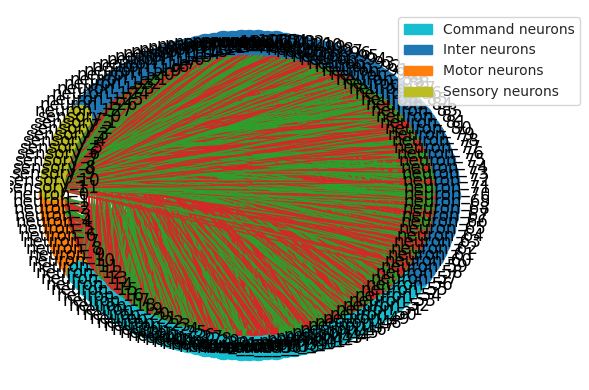

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /content/drive/MyDrive/EC523 Final Project/Results/modelsaves/LTC_G1_itr4 exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | LTC  | 90.0 K
-------------------------------
72.1 K    Trainable params
17.9 K    Non-trainable params
90.0 K    Total params
0.360     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
main()